# Контекст

- Кластеризация текстов на русском языке (Сатьи на разные темы)
- 29 уникальных кластеров
- датасет размером 30 740 образцов
- модель - "paraphrase-distilroberta-base-v1"
- попробовать разные способы кластеризации текстов

In [1]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import numpy as np
from sklearn.cluster import KMeans
import re
import transformers

c:\Users\oudel\AppData\Local\anaconda3\envs\newenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Чтение датасета

In [2]:
# %%script False

ds = load_dataset("ai-forever/ru-scibench-oecd-clustering-p2p")
ds

DatasetDict({
    test: Dataset({
        features: ['sentences', 'labels'],
        num_rows: 30740
    })
})

In [3]:
data = pd.DataFrame(ds['test'])
data.to_csv('data.csv', index = False)
data = pd.read_csv('data.csv')
data.head()

,sentences,labels
0,ИНТЕРНЕТ-ТЕХНОЛОГИИ В МЕЖЭТНИЧЕСКОЙ КОММУНИКАЦ...,Социологические науки
1,ФОРМИРОВАНИЕ КАЧЕСТВА ВОДЫ ГОРЬКОВСКОГО И ЧЕБО...,Социальная и экономическая география
2,ИССЛЕДОВАНИЕ СВАРИВАЕМОСТИ МЕТОДОМ TIG АЛЮМОМА...,Технологии материалов
3,К ВОПРОСУ ОБ ИСПОЛЬЗОВАНИИ ЕВРОПЕЙСКОГО И РОСС...,Социальная и экономическая география
4,ВЗАИМОСВЯЗЬ КОГНИТИВНОГО И ЦЕННОСТНО-СМЫСЛОВОГ...,Психологические науки


Text(0.5, 0, 'кол-во слов')

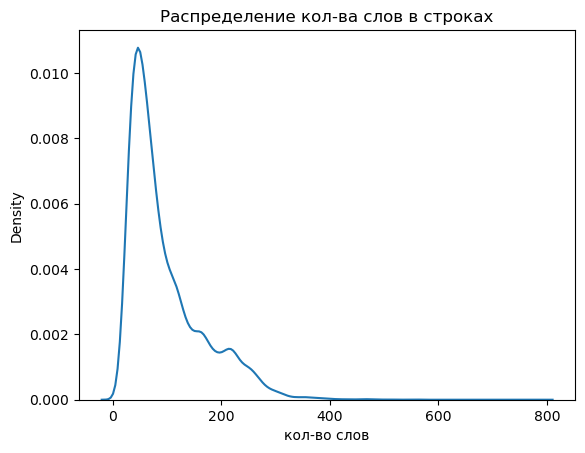

In [4]:
spisok_lens = []
for stroka in data['sentences']:
    spisok_lens.append(len(stroka.split()))

sns.kdeplot(spisok_lens)
plt.title('Распределение кол-ва слов в строках')
plt.xlabel('кол-во слов')

# Скачивание модели SentenceTransformer и кодировка текста

In [5]:
model_path = "paraphrase-distilroberta-base-v1"
model = SentenceTransformer(model_path)

c:\Users\oudel\AppData\Local\anaconda3\envs\newenv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
corpus_embeddings = model.encode(data['sentences'].to_list())
corpus_embeddings.shape

(30740, 768)

# Модель кластеризации

In [7]:
kmeans = KMeans(n_clusters = 5, random_state = 42).fit(corpus_embeddings) # тут можно воспроизводить выбор изначальных точек (random_state = 42)
cls_dist = pd.Series(kmeans.labels_).value_counts()
cls_dist

4    12872
0    10785
2     3861
1     2372
3      850
Name: count, dtype: int64

# Пробуем определить, что за кластеры получились

---

# Центры кластеров (типичные предложения в кластере)

---
Найдем центороид каждого класса и попробуем охарактеризовать тему этих кластеров

In [8]:
distances = scipy.spatial.distance.cdist(
    kmeans.cluster_centers_,
    corpus_embeddings
)

centers = {}
print("Cluster", "Size", "Center-idx", "Center-Example", sep="\t\t")
for i,d in enumerate(distances):
    ind = np.argsort(d, axis=0)[0]
    centers[i]=ind
    print(i,cls_dist[i], ind, data['sentences'].to_list()[ind] ,sep="\t\t")

Cluster		Size		Center-idx		Center-Example
0		10785		5482		КОРРЕКЦИЯ МИЕЛОПОЭЗА У ЖИВОТНЫХ ПРИ КВАНТОВОМ ВОЗДЕЙСТВИИ НА БИОЛОГИЧЕСКИ АКТИВНЫЕ ТОЧКИ. Коррекция миелопоэза у животных обеспечивается облучением лазерно-инфракрасными лучами с помощью квантового терапевтического аппарата для ветеринарной практики «РИКТА-01» (М2В) в течение 3 минут контактным методом частотой 50 Гц области лопатки с левой стороны, где располагается зона биологически активных точек (БАТ), отвечающих за кроветворение. Это приводит к выраженному стимулированию миелопоэза у животных, которое отчетливо заметно на 10 сутки исследования. Далее клеточная реакция миелобластического ростка красного костного мозга на воздействующий фактор несколько снижается, так же это приводит к повышению их иммунного статуса и естественной реактивности организма.
1		2372		28145		Опыт эксплуатации и совершенствования речных док-кессонов. Цель данной работы заключается в сборе, анализе и обобщении информации по эксплуатации речных док-к

- 0 - спорт
- 1 - физика (электроника)
- 2 - корма для животных
- 3 - ветеренария
- 4 - социология

Скорее всего корма для животных и ветеренария это один кластер, можно их, при необходимости, объединить

# Визуализация кластеров (с помощью PCA(n_components = 2))

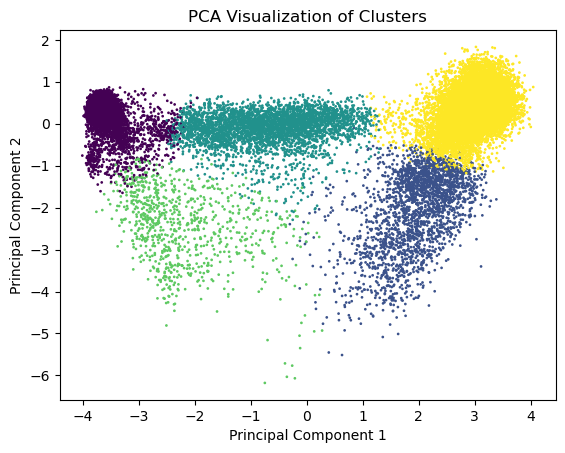

In [9]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Загрузка данных
# data = pd.read_csv("data.csv")

# Создание объекта PCA с двумя компонентами
pca = PCA(n_components = 2)

# Применение PCA к данным
pca_result = pca.fit_transform(corpus_embeddings)

# Создание графика
plt.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c = kmeans.labels_,
    s = 0.9
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Clusters")
plt.show()

# Визуализация с помощью дендограммы

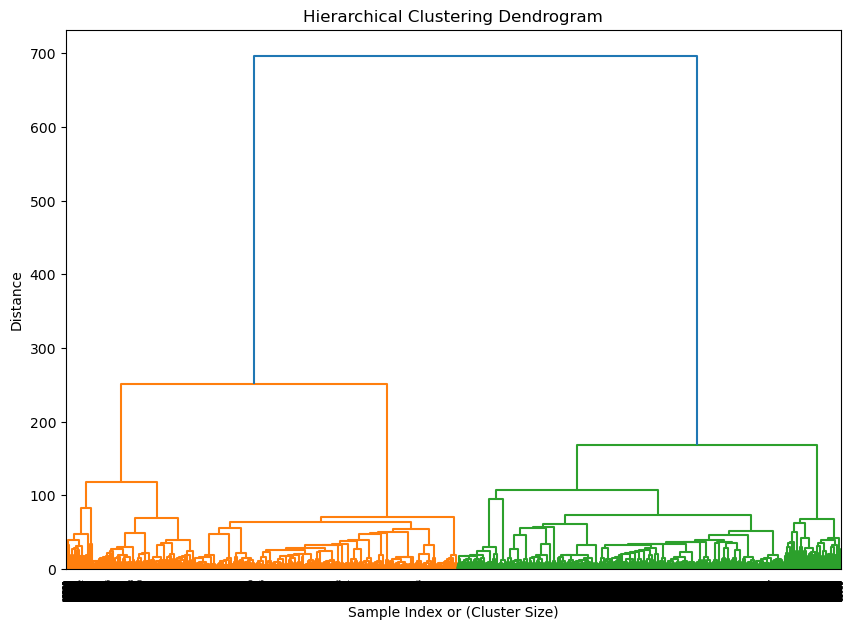

In [23]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_blobs

# 1. Генерация данных
n_samples = 150
n_features = 5
random_state = 42

X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=3,
                   random_state=random_state)

# 2. Построение дендограммы
linked = linkage(corpus_embeddings, 'ward')  # Метод 'ward' для минимизации дисперсии

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True,  # Показать количество объектов в каждом кластере
            # show_truncated_collocations=True,  # Показать только часть дендограммы
            # truncate_mode='level',  # Обрезать дендограмму на определенном уровне
            p=3)  # Уровень обрезки (например, 3 уровня)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.show()

# Тематическое моделирование (более точный способ захвата темы)

---
Популярные методы моделирования тем без учителя:

- Тематическое моделирование латентного распределения Дирихле (LDA)
- Факторизация неотрицательной матрицы (NMF) 
- BERTopic (на основе трансформера)
- top2Vec (на основе трансформера)


---


Шаги BERTopic:

- кодирование предложений (с помощью преобразователей предложений или любой модели встраивания предложений)
-  этап кластеризации, который состоит из двух этапов:
    - уменьшение размерности вложений с помощью UMAP (UMAP - стохастическая модель, поэтому могут давать разные результаты)
    - последующая кластеризация сокращенных векторов с помощью HDBSCAN (похожие документы группируются вместе)
- темы захватываются с помощью кластерного TF-IDF (Вместо того, чтобы извлекать наиболее важные слова в документе, модель извлекает наиболее важные слова в кластере, предоставляя описания тем для каждого кластера)
---

In [10]:
from bertopic import BERTopic


sentence_model = SentenceTransformer("paraphrase-distilroberta-base-v1")
topic_model = BERTopic(embedding_model = sentence_model)
topics, _ = topic_model.fit_transform(data['sentences'].to_list())

In [11]:
topic_model.get_topic_info().to_csv('topic_model_base.csv', index = False)
topic_model = pd.read_csv('topic_model_base.csv')

In [12]:
topic_model.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,9890,-1_на_для_как_по,"['на', 'для', 'как', 'по', 'что', 'при', 'из',...",['Понятие и логика разработки замыслав педагог...
1,0,1238,0_применение_для_по_на,"['применение', 'для', 'по', 'на', 'при', 'повы...",['ПРЕИМУЩЕСТВА ПРЕПОДАВАНИЯ С ИСПОЛЬЗОВАНИЕМ Э...
2,1,1057,1_оценка_особенности_для_на,"['оценка', 'особенности', 'для', 'на', 'по', '...",['Обеспечение кибербезопасности в условиях раз...
3,2,941,2_исследование_использование_для_свойств,"['исследование', 'использование', 'для', 'свой...",['ИСПОЛЬЗОВАНИЕ МАТЕМАТИЧЕСКОГО АНАЛИЗА В МОДЕ...
4,3,853,3_социально_как_совершенствование_на,"['социально', 'как', 'совершенствование', 'на'...",['Совершенствование механизмов обеспечения эко...


- Видим, что стоп-слов. Например: на, как, что и т.д. 
- очистим текст (нижний регистр и т.д.)
- Удалим такие стоп слова и попробуем снова

In [3]:
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = stopwords.words('russian')


def cleaner(text_line, delete_stop_words = False):
    clean_text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ0-9\.\,\!\?\:\;\"\'\(\)\-\s]', '', text_line)
    clean_text = re.sub(r'[\n\r\t\\]', '', clean_text)
    clean_text = clean_text.strip().lower()
    if delete_stop_words:
        new_spisok_tokens_stroki = []
        for token in clean_text.split():
            if token not in stop_words:
                new_spisok_tokens_stroki.append(token)
        clean_text = ' '.join(new_spisok_tokens_stroki)

    return clean_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oudel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
corpus_for_topic_create = [cleaner(stroka, True) for stroka in data['sentences']]

In [15]:
corpus_for_topic_create[0]

'интернет-технологии межэтнической коммуникации. статье рассматривается проблема влияния интернет-технологий процессы межэтнического взаимодействия, содержание направленность межэтнической коммуникации. глобальная сеть предоставляет неограниченные возможности поиска информации культуре народа, изучения языка, общения представителями различных этносов рамках одного государства, уровне международных отношений. интернет стирает границы этнокультурной идентичности, унифицируя информацию помощью виртуальной системы кодирования.'

In [16]:
sentence_model = SentenceTransformer("paraphrase-distilroberta-base-v1")
topic_model_1 = BERTopic(embedding_model = sentence_model)
topics_1, _ = topic_model_1.fit_transform(corpus_for_topic_create)

In [17]:
topic_model_1.get_topic_info().head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,13090,-1_статье_исследования_также_результаты,"[статье, исследования, также, результаты, разв...",[некоторые аспекты повышения конкурентоспособн...
1,0,935,0_анализ_анализа_синтез_результаты,"[анализ, анализа, синтез, результаты, исследов...",[анализ экономической эффективности применения...
2,1,846,1_цель_исследования_это_также,"[цель, исследования, это, также, развития, ста...",[сущность особенности молодёжного предпринимат...
3,2,716,2_обзор_коров_статье_исследования,"[обзор, коров, статье, исследования, также, вы...",[организационных структур институтов проактивн...
4,3,696,3_оценка_концепция_оценки_цифровой,"[оценка, концепция, оценки, цифровой, качества...",[концепция п.я. гальперина эпоху цифровой тран...


In [20]:
topic_model_1.visualize_topics()

можно также,при необходимости , лемматизировать текст

# LDA (латентное распределение Дирихле)


- TF-IDF
- LDA(n_components = предполагаемое кол-во тем)
- lda.components_ - матрица (тема х слово)
- топ N слов для каждой темы
- lda.transform() - вероятность  принадлежности  каждого  документа  к  каждой  теме

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

# 1. Подготовка данных
documents = corpus_for_topic_create
# 2. Создание TF-IDF вектора
vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2)
tfidf = vectorizer.fit_transform(documents)

# 3. Создание модели LDA
lda = LatentDirichletAllocation(n_components = 5, random_state=42)

# 4. Обучение модели
lda.fit(tfidf)

# 5. Вывод тем и ключевых слов
n_top_words = 10
for topic_idx, topic in enumerate(lda.components_):
    print(f"Тема {topic_idx + 1}:")
    print(", ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

# 6. Получение темы для каждого документа
topic_distribution = lda.transform(tfidf)
topics = topic_distribution.argmax(axis = 1)
print(f"Темы для документов: {topics}")

# 7. Создание DataFrame для анализа
df = pd.DataFrame({'Document': documents, 'Topic': topics})

Тема 1:
влияние, результаты, животных, установлено, коров, свойства, исследования, методом, основе, показано

Тема 2:
системы, управления, статье, развития, систем, анализ, основе, рассмотрены, оценки, данных

Тема 3:
the, of, and, залива, in, to, артиллерии, та, бан, is

Тема 4:
физической, спортсменов, спорта, подготовленности, спортивной, сортов, пшеницы, подготовки, студентов, занятий

Тема 5:
статье, развития, деятельности, россии, статья, автор, образования, рассматриваются, исследования, культуры

Темы для документов: [4 1 0 ... 1 1 0]


In [11]:
lda.components_.shape

(5, 89276)

In [9]:
df.head()

,Document,Topic
0,интернет-технологии межэтнической коммуникации...,4
1,формирование качества воды горьковского чебокс...,1
2,исследование свариваемости методом tig алюмома...,0
3,вопросу использовании европейского российского...,4
4,взаимосвязь когнитивного ценностно-смыслового ...,4


# NMF (Факторизация неотрицательной матрицы)

- TF-IDF
- модель NMF(n_components = кол-во тем) обучение на TF-IDF
- nmf.components_ - матрица (тема х слово)
- топ N слов для каждой темы
- nmf.transform() - вероятность  принадлежности  каждого  документа  к  каждой  теме

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import pandas as pd

# 1. Подготовка данных
documents = corpus_for_topic_create
# 2. Создание TF-IDF вектора
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
tfidf = vectorizer.fit_transform(documents)

# 3. Создание модели NMF
nmf = NMF(n_components=5, random_state=42)

# 4. Обучение модели
nmf.fit(tfidf)

# 5. Вывод тем и ключевых слов
n_top_words = 10
for topic_idx, topic in enumerate(nmf.components_):
    print(f"Тема {topic_idx + 1}:")
    print(", ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

# 6. Получение темы для каждого документа
topic_distribution = nmf.transform(tfidf)
topics = topic_distribution.argmax(axis=1)
print(f"Темы для документов: {topics}")

# 7. Создание DataFrame для анализа
df = pd.DataFrame({'Document': documents, 'Topic': topics})

Тема 1:
развития, россии, статье, российской, проблемы, общества, автор, социально, статья, политики

Тема 2:
результаты, основе, материалов, исследования, параметров, модели, свойств, влияние, процесса, свойства

Тема 3:
коров, животных, крови, породы, скота, рогатого, крупного, группы, кг, продуктивности

Тема 4:
студентов, деятельности, образования, обучения, профессиональной, подготовки, физической, культуры, формирования, профессионального

Тема 5:
управления, системы, систем, безопасности, решения, задачи, обеспечения, эффективности, система, контроля

Темы для документов: [0 1 1 ... 4 4 1]
